<a href="https://colab.research.google.com/github/Harshita-Puthran/factverse/blob/main/application_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*INSTALL DEPENDENCIES*

In [4]:
!pip install transformers datasets evaluate rouge_score sacrebleu -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Trainer, TrainingArguments
import evaluate

In [6]:
import pandas as pd
df = pd.read_json("hf://datasets/glnmario/news-qa-summarization/data.jsonl", lines=True)

In [2]:
df.head(5)

,story,questions,answers,summary
0,"'SINDH KALAY', England (CNN) -- The aroma of f...","[Where were they being deployed to?, What does...","[[Afghanistan's Helmand province], [how the pe...",British soldiers train in mock Afghan village ...
1,"(AOL Autos) -- At the 2009 Detroit Auto Show,...","[What debuts at the 2009 Detroit Auto Show?, W...","[[electric vehicles], [Chrysler, Mercedes-Benz...",Latest technologies debut at the 2009 Detroit ...
2,(AOL Autos) -- Buying a used car may seem lik...,"[What does Texas have?, What will the average ...",[[has more used vehicles than any other state]...,Three out of four transactions in the U.S. inv...
3,(AOL Autos) -- Collecting cars is an expensiv...,"[What can compete with the Mercedes SL Class?,...","[[Cadillac XLR-V], [hatchback,], [hatchback,],...",The right new car today could be worth a fortu...
4,(AOL Autos) -- Have you ever wondered what yo...,"[what did the report try to uncover?, What do ...",[[secret contents of the average American trun...,Reporter tries to uncover secret contents of a...


In [7]:
import re
from bs4 import BeautifulSoup

def clean_text_extended(text):
    text = str(text)
    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Fix encoding issues
    text = text.replace("\xa0", " ").replace("&amp;", "&")

    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 4. Remove special characters (keep basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9.,;!?()’'\"-]", " ", text)

    # 5. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df["story"] = df["story"].apply(clean_text_extended)
df["summary"] = df["summary"].apply(clean_text_extended)

print(df.head())


                                               story  \
0  'SINDH KALAY', England (CNN) -- The aroma of f...   
1  (AOL Autos) -- At the 2009 Detroit Auto Show, ...   
2  (AOL Autos) -- Buying a used car may seem like...   
3  (AOL Autos) -- Collecting cars is an expensive...   
4  (AOL Autos) -- Have you ever wondered what you...   

                                           questions  \
0  [Where were they being deployed to?, What does...   
1  [What debuts at the 2009 Detroit Auto Show?, W...   
2  [What does Texas have?, What will the average ...   
3  [What can compete with the Mercedes SL Class?,...   
4  [what did the report try to uncover?, What do ...   

                                             answers  \
0  [[Afghanistan's Helmand province], [how the pe...   
1  [[electric vehicles], [Chrysler, Mercedes-Benz...   
2  [[has more used vehicles than any other state]...   
3  [[Cadillac XLR-V], [hatchback,], [hatchback,],...   
4  [[secret contents of the average American t

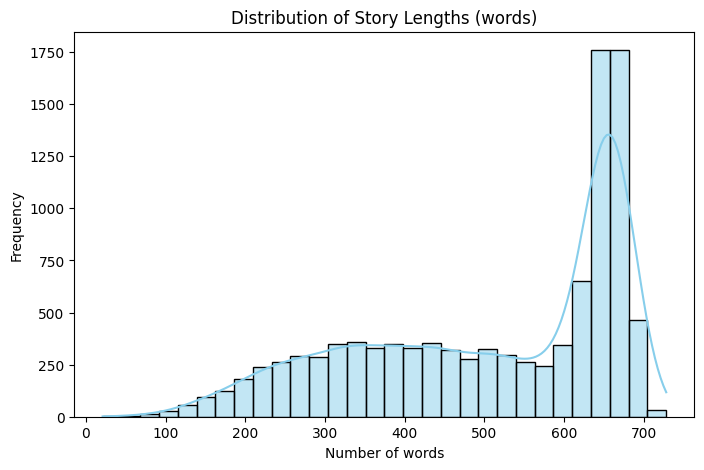

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df['story_len'] = df['story'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df['story_len'], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Story Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


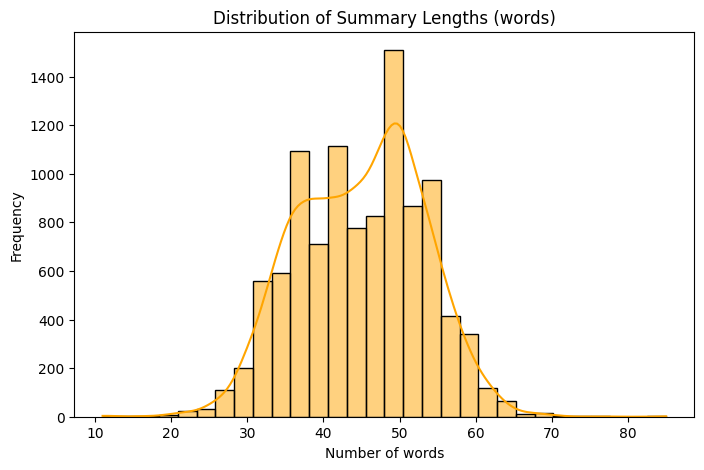

In [9]:
df['summary_len'] = df['summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df['summary_len'], bins=30, kde=True, color="orange")
plt.title("Distribution of Summary Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


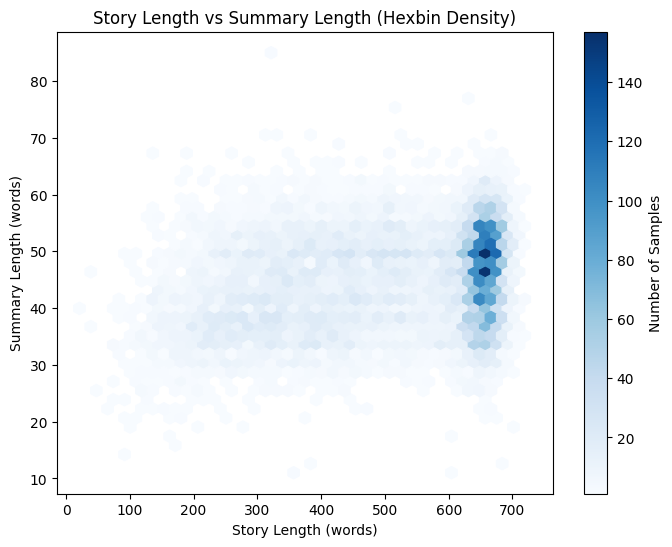

In [12]:
plt.figure(figsize=(8,6))
plt.hexbin(df['story_len'], df['summary_len'], gridsize=40, cmap="Blues", mincnt=1)
plt.colorbar(label="Number of Samples")
plt.title("Story Length vs Summary Length (Hexbin Density)")
plt.xlabel("Story Length (words)")
plt.ylabel("Summary Length (words)")
plt.show()


